In [20]:
import sys
sys.path.insert(0, "/Users/namirjawdat/Projects/manipulation")
import manipulation

In [21]:
# from pydrake.geometry.render import RenderLabel
import copy
from functools import partial
import matplotlib.pyplot as plt
import mpld3
import numpy as np
import os
import pydot
import time
from IPython.display import SVG, HTML, display, Markdown

from pydrake.all import (
	AddMultibodyPlantSceneGraph,
	AddUnitQuaternionConstraintOnPlant,
  AddMultibodyPlant,
  AddWeld,
	AutoDiffXd,
  ComInPolyhedronConstraint,
	DiagramBuilder,
	ExtractGradient,
	ExtractValue,
	InitializeAutoDiff,
	JacobianWrtVariable,
	JointIndex,
	MathematicalProgram,
	MeshcatVisualizer,
	MultibodyPlant,
	OrientationConstraint,
	Parser,
	PidController,
	PiecewisePolynomial,
	PositionConstraint,
  Rgba,
	RigidTransform,
  RollPitchYaw,
	RotationMatrix,
	Simulator,
	SnoptSolver,
	Solve,
  Sphere,
	StartMeshcat,
  ToLatex,
  LogVectorOutput,
	eq,
	namedview,
	ModelVisualizer,
	GraphOfConvexSets,
	GraphOfConvexSetsOptions,
	HPolyhedron,
	Point,
  VPolytope,
)

# from manipulation.meshcat_utils import MeshcatPoseSliders, WsgButton

from underactuated import ConfigureParser, multibody, running_as_notebook

In [22]:
# Start the visualizer (run this cell only once, each instance consumes a port)
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7006


In [23]:
def set_home(plant, context):
  PositionView = namedview(
      "Positions",
      plant.GetPositionNames(always_add_suffix=False, add_model_instance_prefix=True),
  )
  positionFields = PositionView.get_fields()
  hip_roll = -0.05
  front_hip_pitch = -0.6
  rear_hip_pitch = -0.9
  knee = 1.55
  q0 = PositionView(np.zeros(len(positionFields)))
  q0.spot_front_right_hip_roll = -hip_roll
  q0.spot_front_right_hip_pitch = front_hip_pitch
  q0.spot_front_right_knee = knee
  q0.spot_front_left_hip_roll = hip_roll
  q0.spot_front_left_hip_pitch = front_hip_pitch
  q0.spot_front_left_knee = knee
  q0.spot_rear_right_hip_roll = -hip_roll
  q0.spot_rear_right_hip_pitch = rear_hip_pitch
  q0.spot_rear_right_knee = knee
  q0.spot_rear_left_hip_roll = hip_roll
  q0.spot_rear_left_hip_pitch = rear_hip_pitch
  q0.spot_rear_left_knee = knee
  q0.spot_arm_shoulder_roll = 0*np.pi/180
  q0.spot_arm_shoulder_pitch = 0*np.pi/180
  q0.spot_arm_elbow_pitch = 0*np.pi/180
  q0.spot_arm_lower_arm_roll = 0*np.pi/180
  q0.spot_arm_wrist_pitch = 0*np.pi/180
  q0.spot_arm_wrist_roll = 0*np.pi/180
  q0.spot_arm_finger_pitch = 0*np.pi/180
  q0.spot_world_body_qw = 1.0  # Unit quaternion
  q0.spot_world_body_z =0.528
  plant.SetPositions(context, q0[:])

def set_qf(qf_view, command_increment, shoulder_roll_cmd, shoulder_pitch_cmd, elbow_pitch_cmd, lower_arm_roll_cmd, wrist_pitch_cmd, wrist_roll_cmd, finger_pitch_cmd):
  if qf_view.spot_arm_shoulder_roll > shoulder_roll_cmd:
    qf_view.spot_arm_shoulder_roll -= command_increment
    if qf_view.spot_arm_shoulder_roll < shoulder_roll_cmd:
      qf_view.spot_arm_shoulder_roll = shoulder_roll_cmd
  
  if qf_view.spot_arm_shoulder_roll < shoulder_roll_cmd:
    qf_view.spot_arm_shoulder_roll += command_increment
    if qf_view.spot_arm_shoulder_roll > shoulder_roll_cmd:
      qf_view.spot_arm_shoulder_roll = shoulder_roll_cmd


  if qf_view.spot_arm_shoulder_pitch > shoulder_pitch_cmd:
    qf_view.spot_arm_shoulder_pitch -= command_increment
    if qf_view.spot_arm_shoulder_pitch < shoulder_pitch_cmd:
      qf_view.spot_arm_shoulder_pitch = shoulder_pitch_cmd
  
  if qf_view.spot_arm_shoulder_pitch < shoulder_pitch_cmd:
    qf_view.spot_arm_shoulder_pitch += command_increment
    if qf_view.spot_arm_shoulder_pitch > shoulder_pitch_cmd:
      qf_view.spot_arm_shoulder_pitch = shoulder_pitch_cmd

  if qf_view.spot_arm_elbow_pitch > elbow_pitch_cmd:
    qf_view.spot_arm_elbow_pitch -= command_increment
    if qf_view.spot_arm_elbow_pitch < elbow_pitch_cmd:
      qf_view.spot_arm_elbow_pitch = elbow_pitch_cmd

  if qf_view.spot_arm_elbow_pitch < elbow_pitch_cmd:
    qf_view.spot_arm_elbow_pitch += command_increment
    if qf_view.spot_arm_elbow_pitch > elbow_pitch_cmd:
      qf_view.spot_arm_elbow_pitch = elbow_pitch_cmd

  if qf_view.spot_arm_lower_arm_roll > lower_arm_roll_cmd:
    qf_view.spot_arm_lower_arm_roll -= command_increment
    if qf_view.spot_arm_lower_arm_roll < lower_arm_roll_cmd:
      qf_view.spot_arm_lower_arm_roll = lower_arm_roll_cmd

  if qf_view.spot_arm_lower_arm_roll < lower_arm_roll_cmd:
    qf_view.spot_arm_lower_arm_roll += command_increment
    if qf_view.spot_arm_lower_arm_roll > lower_arm_roll_cmd:
      qf_view.spot_arm_lower_arm_roll = lower_arm_roll_cmd

  if qf_view.spot_arm_wrist_pitch > wrist_pitch_cmd:
    qf_view.spot_arm_wrist_pitch -= command_increment
    if qf_view.spot_arm_wrist_pitch < wrist_pitch_cmd:
      qf_view.spot_arm_wrist_pitch = wrist_pitch_cmd

  if qf_view.spot_arm_wrist_pitch < wrist_pitch_cmd:
    qf_view.spot_arm_wrist_pitch += command_increment
    if qf_view.spot_arm_wrist_pitch > wrist_pitch_cmd:
      qf_view.spot_arm_wrist_pitch = wrist_pitch_cmd

  if qf_view.spot_arm_wrist_roll > wrist_roll_cmd:
    qf_view.spot_arm_wrist_roll -= command_increment
    if qf_view.spot_arm_wrist_roll < wrist_roll_cmd:
      qf_view.spot_arm_wrist_roll = wrist_roll_cmd

  if qf_view.spot_arm_wrist_roll < wrist_roll_cmd:
    qf_view.spot_arm_wrist_roll += command_increment
    if qf_view.spot_arm_wrist_roll > wrist_roll_cmd:
      qf_view.spot_arm_wrist_roll = wrist_roll_cmd

  if qf_view.spot_arm_finger_pitch > finger_pitch_cmd:
    qf_view.spot_arm_finger_pitch -= command_increment
    if qf_view.spot_arm_finger_pitch < finger_pitch_cmd:
      qf_view.spot_arm_finger_pitch = finger_pitch_cmd

  if qf_view.spot_arm_finger_pitch < finger_pitch_cmd:
    qf_view.spot_arm_finger_pitch += command_increment
    if qf_view.spot_arm_finger_pitch > finger_pitch_cmd:
      qf_view.spot_arm_finger_pitch = finger_pitch_cmd
  return qf_view

def add_spot_arm_sliders(x0):
  meshcat.AddButton("Stop")
  meshcat.AddSlider(
    "shoulder_roll",
    0,
    5.759586531581288,
    1e-6,
    x0[12]
  )

  meshcat.AddSlider(
    "shoulder_pitch",
    0,
    3.665191429188092,
    1e-6,
    x0[13]
  )

  meshcat.AddSlider(
    "elbow_pitch",
    0,
    3.141592653589793,
    1e-6,
    x0[14]
  )

  meshcat.AddSlider(
    "lower_arm_roll",
    -2.792526803190927,
    2.792526803190927,
    1e-6,
    x0[15]
  )

  meshcat.AddSlider(
    "wrist_pitch",
    -1.570796,
    1.570796,
    1e-6,
    x0[16]
  )

  meshcat.AddSlider(
    "wrist_roll",
    -2.879793265790644,
    2.879793265790644,
    1e-6,
    x0[17]
  )

  meshcat.AddSlider(
    "finger_pitch",
    0,
    1.570796326794897,
    1e-6,
    x0[18]
  )

def create_pid_controller(builder, plant):
  num_actuators = plant.num_actuators()
  kp = 300.0 * np.ones(num_actuators)
  ki = 3.0 * np.ones(num_actuators)
  kd = 30.0 * np.ones(num_actuators)
  # Select the joint states (and ignore the floating-base states)
  num_q = plant.num_positions()
  num_q_dot = plant.num_velocities()
  S = np.zeros((2*num_actuators, (num_q + num_q_dot)))

  j = 0
  for jointIdx in range(plant.num_joints()):
    joint = plant.get_joint(JointIndex(jointIdx))
    if joint.num_positions() != 1:
      # print(f'Joint[{jointIdx}] {joint.name()} is not considered')
      continue
    # print(f'Joint[{jointIdx}] {joint.name()} is considered')
    # print(f'{joint.name()} position start {joint.position_start()} and velocity start {joint.velocity_start()}' )
    S[j, joint.position_start()] = 1
    S[num_actuators + j, num_q + joint.velocity_start()] = 1
    # use lower gain for the knee joints
    if "knee" in joint.name():
      kd[j] = 6
    j = j + 1

  controller = builder.AddSystem(
    PidController(
      kp=kp,
      ki=ki,
      kd=kd,
      state_projection=S,
      output_projection=plant.MakeActuationMatrix()[6:].T,
    )
  )

  return controller, S

controller desired state inputs are 38
S shape: (38, 51)
state_output_port shape: (51,)
full plan positions: (26,)
full plan velocities: (25,)
x0 shape: (38,)
positionFields: ('spot_world_body_qw', 'spot_world_body_qx', 'spot_world_body_qy', 'spot_world_body_qz', 'spot_world_body_x', 'spot_world_body_y', 'spot_world_body_z', 'spot_front_left_hip_roll', 'spot_front_left_hip_pitch', 'spot_front_left_knee', 'spot_front_right_hip_roll', 'spot_front_right_hip_pitch', 'spot_front_right_knee', 'spot_rear_left_hip_roll', 'spot_rear_left_hip_pitch', 'spot_rear_left_knee', 'spot_rear_right_hip_roll', 'spot_rear_right_hip_pitch', 'spot_rear_right_knee', 'spot_arm_shoulder_roll', 'spot_arm_shoulder_pitch', 'spot_arm_elbow_pitch', 'spot_arm_lower_arm_roll', 'spot_arm_wrist_pitch', 'spot_arm_wrist_roll', 'spot_arm_finger_pitch')

positionFields shape: 26


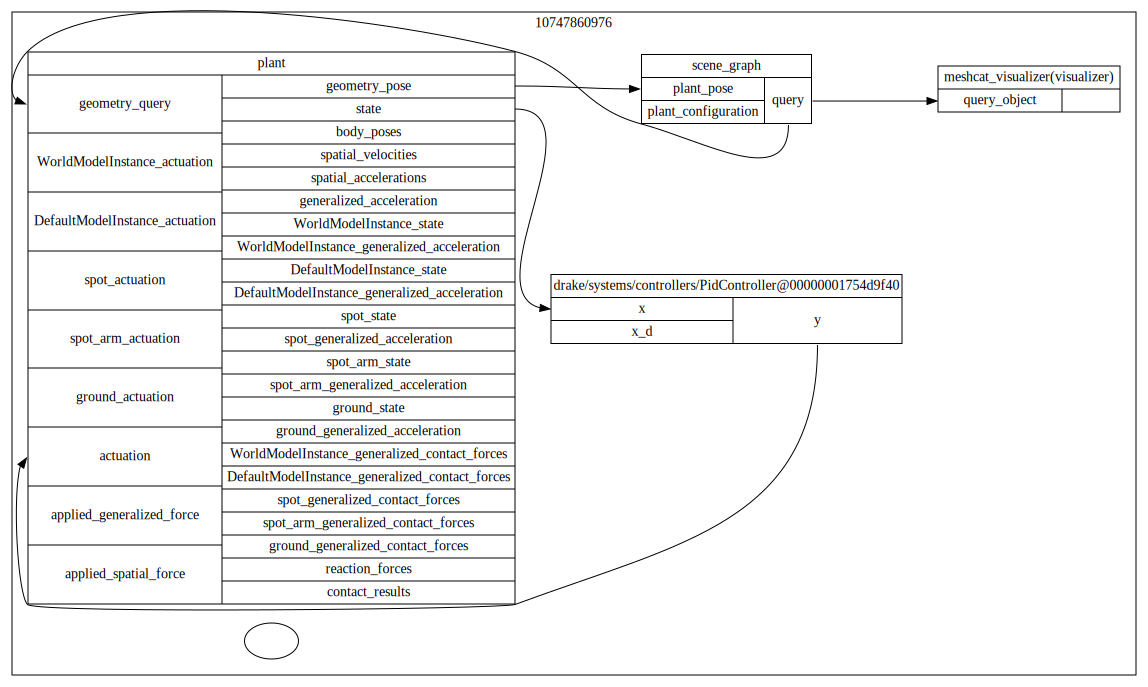

In [27]:
def run_pid_control():
  current_os_path = os.getcwd()
  builder = DiagramBuilder()
  plant, scene_graph = AddMultibodyPlantSceneGraph(builder, 1e-5)
  parser = Parser(plant)
  # ConfigureParser(parser)
  (spot,) = parser.AddModelsFromUrl(
      f"file://{current_os_path}/spot_description/urdf/spot.urdf"
  )
  (spot_arm,) = parser.AddModelsFromUrl(
      f"file://{current_os_path}/spot_description/urdf/spot_arm.urdf"
  )
  (ground,) = parser.AddModelsFromUrl(
      f"file://{current_os_path}/spot_description/urdf/ground.urdf"
  )
  weld_joint = plant.WeldFrames(plant.GetFrameByName("body", spot), plant.GetFrameByName("arm_base", spot_arm), RigidTransform(RollPitchYaw(1.570796326794897, 0, 0), [0.29, 0.0, 0.11]))

  plant.Finalize()

  # display(SVG(pydot.graph_from_dot_data(
  # plant.GetGraphvizString(max_depth=2))[0].create_svg()))

  control, S = create_pid_controller(builder, plant)
  builder.Connect(
      plant.get_state_output_port(), control.get_input_port_estimated_state()
  )
  builder.Connect(
      control.get_output_port(), plant.get_actuation_input_port()
  )

  print(f"controller desired state inputs are {control.get_input_port_desired_state().size()}")

  visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
  
  # stateLogger = LogVectorOutput(plant.get_state_output_port(), builder)
  # contollerLogger = LogVectorOutput(control.get_output_port(), builder)
  
  diagram = builder.Build()
  simulator = Simulator(diagram)
  context = simulator.get_mutable_context()
  plant_context = plant.GetMyContextFromRoot(context)
  set_home(plant, plant_context)
  x0 = S @ plant.get_state_output_port().Eval(plant_context)

  print(f"S shape: {S.shape}")
  print(f"state_output_port shape: {plant.get_state_output_port().Eval(plant_context).shape}")
  print(f"full plan positions: {plant.GetPositions(plant_context).shape}")
  print(f"full plan velocities: {plant.GetVelocities(plant_context).shape}")
  print(f"x0 shape: {x0.shape}")
  PositionView = namedview(
      "Positions",
      plant.GetPositionNames(always_add_suffix=False, add_model_instance_prefix=True),
  )

  positionFields = PositionView.get_fields()
#   print(f'positions: {PositionView(np.zeros(plant.num_positions()))}\n')
  print(f'positionFields: {positionFields}\n')
  print(f"positionFields shape: {len(positionFields)}")

  VelocityView = namedview(
      "Velocities",
      plant.GetVelocityNames(always_add_suffix=False, add_model_instance_prefix=True),
  )

  velocityFields = VelocityView.get_fields()

  ActuationView = namedview(
    "Actuation",
    plant.GetActuatorNames(add_model_instance_prefix=True
    ),
  )
  actuationFields = ActuationView.get_fields()
  # print(f'actuators: {ActuationView(np.zeros(plant.num_actuators()))}\n')
  # print(f'actuationFields: {actuationFields}\n')

  control.get_input_port_desired_state().FixValue(
      control.GetMyContextFromRoot(context), x0
  )

  

  simulator.set_target_realtime_rate(1.0 if running_as_notebook else 0)
  visualizer.StartRecording()
  com_pose_in_world = plant.CalcCenterOfMassPositionInWorld(plant_context)
  meshcat.SetObject("CoM", Sphere(0.03), Rgba(0, 0, 1, 1))
  com_pose_in_world[2] = 0
  meshcat.SetTransform(
      "CoM", RigidTransform(com_pose_in_world)
  )

  foot_frame = [
    plant.GetFrameByName("front_left_foot_center"),
    plant.GetFrameByName("front_right_foot_center"),
    plant.GetFrameByName("rear_left_foot_center"),
    plant.GetFrameByName("rear_right_foot_center"),
  ]
  for i in range(4):
    meshcat.SetObject(f"foot_{i}", Sphere(0.03), Rgba(1, 0, 0, 1)) 
    
  foot_pose_in_world = [foot_frame[i].CalcPoseInWorld(plant_context) for i in range(4)]
  for i in range(4):
    foot_projection_in_world = np.zeros(3)
    foot_projection_in_world[:2] = foot_pose_in_world[i].translation()[:2]
    meshcat.SetTransform(f"foot_{i}", foot_pose_in_world[i])
    
  add_spot_arm_sliders(x0)
  q0 = plant.GetPositions(plant_context)
  v0 = plant.GetVelocities(plant_context)
  q0_view = PositionView(q0)
  v0_view = VelocityView(v0)
  qf_view = copy.deepcopy(q0_view)
  servo_rpm = 30
  timeStep = 0.01
  while meshcat.GetButtonClicks("Stop") < 1:
    shoulder_roll_cmd = meshcat.GetSliderValue("shoulder_roll")
    shoulder_pitch_cmd = meshcat.GetSliderValue("shoulder_pitch")
    elbow_pitch_cmd = meshcat.GetSliderValue("elbow_pitch")
    lower_arm_roll_cmd = meshcat.GetSliderValue("lower_arm_roll")
    wrist_pitch_cmd = meshcat.GetSliderValue("wrist_pitch")
    wrist_roll_cmd = meshcat.GetSliderValue("wrist_roll")
    finger_pitch_cmd = meshcat.GetSliderValue("finger_pitch")
    command_increment = ((servo_rpm * 2 * np.pi)/60) * timeStep
    qf_view = set_qf(qf_view, command_increment, shoulder_roll_cmd, shoulder_pitch_cmd, elbow_pitch_cmd, lower_arm_roll_cmd, wrist_pitch_cmd, wrist_roll_cmd, finger_pitch_cmd)
    position_and_velocity = np.zeros((51))
    position_and_velocity[:26] = qf_view[:]

    x0 = S @ position_and_velocity
    control.get_input_port_desired_state().FixValue(
        control.GetMyContextFromRoot(context), x0
    )
    simulator.AdvanceTo(simulator.get_context().get_time() + timeStep)
    com_pose_in_world = plant.CalcCenterOfMassPositionInWorld(plant_context)
    com_pose_in_world[2] = 0
    meshcat.SetTransform(
        "CoM", RigidTransform(com_pose_in_world)
    )

    foot_pose_in_world = [foot_frame[i].CalcPoseInWorld(plant_context) for i in range(4)]
    for i in range(4):
      foot_projection_in_world = np.zeros(3)
      foot_projection_in_world[:2] = foot_pose_in_world[i].translation()[:2]
      meshcat.SetTransform(f"foot_{i}", foot_pose_in_world[i])


  display(SVG(pydot.graph_from_dot_data(
  diagram.GetGraphvizString(max_depth=2))[0].create_svg()))

  visualizer.PublishRecording()
  meshcat.DeleteAddedControls()
  meshcat.Delete("CoM")
  for i in range(4):
    meshcat.Delete(f"foot_{i}") 
  # Plot the results
  # stateLog = stateLogger.FindLog(context)
  # # print(f'stateLog data size: {stateLog.data().shape}')
  # controllerLog = contollerLogger.FindLog(context)
  # for i in range(plant.num_joints()):
  #   joint = plant.get_joint(JointIndex(i))
  #   if joint.num_positions() != 1:
  #     continue
  #   idx = actuationFields.index(joint.name())
  #   jdx = joint.position_start()
  #   wdx = num_q + joint.velocity_start()
  #   plt.figure()
  #   plt.subplot(3, 1, 1)
  #   refPosition = x0[idx] * np.ones(len(stateLog.sample_times()))
  #   # print(f'refPosition: {refPosition}\n')
  #   # print(f'stateLog.data()[jdx, :].transpose(): {stateLog.data()[jdx, :].transpose()}\n')
  #   plt.plot(stateLog.sample_times(), stateLog.data()[jdx, :].transpose())
  #   plt.plot(stateLog.sample_times(), refPosition)
  #   plt.legend(["position", "desired position"])
  #   plt.ylabel("Position")
  #   plt.title(actuationFields[idx])
  #   plt.grid(True)
  #   plt.subplot(3, 1, 2)
  #   refVelocity = x0[idx+num_actuators] * np.ones(len(stateLog.sample_times()))
  #   # print(f'refVelocity: {refVelocity}\n')
  #   # print(f'stateLog.data()[wdx, :].transpose(): {stateLog.data()[jdx, :].transpose()}\n')
  #   plt.plot(stateLog.sample_times(), stateLog.data()[wdx, :].transpose())
  #   plt.plot(stateLog.sample_times(), refVelocity)
  #   plt.legend(["velocity", "desired velocity"])
  #   plt.ylabel("Velocity")
  #   plt.grid(True)
  #   plt.subplot(3, 1, 3)
  #   plt.plot(controllerLog.sample_times(), controllerLog.data()[idx, :].transpose())
  #   plt.legend(["Actuation"])
  #   plt.xlabel('t')
  #   plt.ylabel(actuationFields[idx])
  #   plt.grid(True)
  #   plt.savefig(actuationFields[idx] + ".jpg")
    # display(mpld3.display())
  
run_pid_control()